In [1]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
import json
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import umap

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import regu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
importlib.reload(basicu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

input_csv = f'{res_dir}noHarmony_March30_v4_isocortex_hpf.csv'
print(input_csv)

output_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_April14.csv'
output2_csv = f'{res_dir}Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv'
print(output_csv)
print(output2_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'

# allen tree
allen_tree_path='/bigstore/GeneralStorage/fangming/reference/allen_ccf/structures.json'

# analysis metadata
meta_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/analysis_meta_Mar31.json'


/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/noHarmony_March30_v4_isocortex_hpf.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_April14.csv
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_isocortex_hpf_subsamp100_level1_April14.csv


In [4]:
%%time
# results
dftypes = pd.read_csv(input_csv, index_col=0)
dftypes = dftypes.filter(regex=r'^Level_[0-9]', axis=1)
levels = dftypes.columns.values

# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
data.obs = data.obs.join(dftypes)

# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

# allen tree
allen_tree, allen_maps = regu.load_allen_tree(allen_tree_path)

# analysis
with open(meta_path, 'r') as fh:
    meta = json.load(fh)


from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 687 ms, sys: 173 ms, total: 860 ms
Wall time: 862 ms


In [5]:
ref_data.obs = ref_data.obs.rename({
                                    'class_label': 'Level_1_class_label',
                                    'neighborhood_label': 'Level_2_neighborhood_label',
                                    'subclass_label': 'Level_3_subclass_label',
                                    'cluster_label': 'Level_5_cluster_label',
                                    }, axis=1)
ref_data

AnnData object with n_obs × n_vars = 73347 × 24
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'Level_5_cluster_label', 'cluster_color', 'subclass_order', 'Level_3_subclass_label', 'subclass_color', 'neighborhood_id', 'Level_2_neighborhood_label', 'neighborhood_color', 'class_order', 'Level_1_class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label',

In [6]:
# select specific regions
selected_regions = ['Isocortex', 'HPF']
selected_all_sids = regu.expand_regions(allen_tree, selected_regions, 'acronym')

# selected cells
cond_cells = data.obs['region_id'].isin(selected_all_sids)
data = data[cond_cells]
data

View of AnnData object with n_obs × n_vars = 44075 × 24
    obs: 'label', 'pixel_x', 'pixel_y', 'nuclei_size', 'nuclei_signal', 'cytoplasm_size', 'cytoplasm_signal', 'total_size', 'total_signal', 'posname', 'posname_stage_x', 'posname_stage_y', 'cell_name', 'stage_x', 'stage_y', 'coord_x', 'coord_y', 'region_id', 'region_color', 'region_acronym', 'Level_1_class_label', 'Level_2_neighborhood_label', 'Level_3_subclass_label'
    obsm: 'stage'
    layers: 'cytoplasm_vectors', 'nuclei_vectors', 'total_vectors', 'norm_cell'

In [7]:
def get_umap(Xcell, Ycell, 
             Xidx, Yidx, 
             Xname, Yname,
             **kwargs):
    """
    """
    # run UMAP
    embed = umap.UMAP(**kwargs).fit_transform(
        np.vstack([Xcell, Ycell])
        )

    dfembed = pd.DataFrame(index=np.hstack([Xidx, Yidx])) 
    dfembed['dataset'] = [Xname]*len(Xidx) + [Yname]*len(Yidx) 
    dfembed['embed_1'] = embed[:,0]
    dfembed['embed_2'] = embed[:,1]
    
    return dfembed 

In [8]:
# %%time
# Xcell = basicu.zscore(ref_data.X, axis=0)
# Ycell = basicu.zscore(data.layers['norm_cell'], axis=0)
# print(Xcell.shape, Ycell.shape)

# dfembed = get_umap(Xcell, Ycell, 
#                  ref_data.obs.index.values, data.obs.index.values,
#                  'scRNA-seq', 'dredFISH',
#                 )
# dfembed

In [9]:
# print(output_csv)
# dfembed.to_csv(output_csv, index=True, header=True)

# subsample by class 

In [10]:
X = ref_data.X/ref_data.X.sum(axis=1).reshape(-1,1)
Y = data.layers['norm_cell']
# level = 'Level_1_class_label'
# n = 100

# dfsub, xidx = basicu.stratified_sample(ref_data.obs, level, n, return_idx=True)
# Xcell = basicu.zscore(X[xidx], axis=0)
Xcell = X #basicu.zscore(X, axis=0)
Ycell = Y # basicu.zscore(Y, axis=0)

Xcell.shape, Ycell.shape

((73347, 24), (44075, 24))

In [11]:
%%time
dfembed = get_umap(Xcell, Ycell, 
                   ref_data.obs.index.values,
                   data.obs.index.values,
                   'scRNA-seq', 'dredFISH',
                   verbose=True,
                   metric='correlation',
                 )
output2_csv = f'{res_dir}Joint_UMAP_cellnorm_corrdist_April14.csv'
print(output2_csv)
dfembed.to_csv(output2_csv, index=True, header=True)
dfembed

UMAP(angular_rp_forest=True, metric='correlation', verbose=True)
Thu Apr 14 11:41:58 2022 Construct fuzzy simplicial set
Thu Apr 14 11:41:58 2022 Finding Nearest Neighbors
Thu Apr 14 11:41:58 2022 Building RP forest with 22 trees
Thu Apr 14 11:41:58 2022 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Thu Apr 14 11:42:22 2022 Finished Nearest Neighbor Search
Thu Apr 14 11:42:25 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Thu Apr 14 11:44:50 2022 Finished embedding
/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_cellnorm_corrdist_April14.csv
CPU times: user 1h 56min 27s, sys: 2min 7s, total: 1h 58min 35s
Wall time: 2min 52s


,dataset,embed_1,embed_2
US-1250273_E1_S37,scRNA-seq,10.778220,10.651604
US-1250273_E2_S01,scRNA-seq,10.733010,10.636397
US-1250273_E2_S02,scRNA-seq,10.479274,10.803296
US-1250273_E2_S03,scRNA-seq,12.060718,14.525657
US-1250273_E2_S04,scRNA-seq,10.958053,11.070027
...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,dredFISH,-4.530399,4.345376
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,dredFISH,3.306587,9.713432
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,dredFISH,3.083130,9.410065
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,dredFISH,3.581017,9.974312


In [12]:
f = output2_csv 
# f = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/Joint_UMAP_corrdist_April14.csv'
dfembed = pd.read_csv(f, index_col=0)

In [13]:
dfembed

,dataset,embed_1,embed_2
US-1250273_E1_S37,scRNA-seq,10.778220,10.651604
US-1250273_E2_S01,scRNA-seq,10.733010,10.636397
US-1250273_E2_S02,scRNA-seq,10.479274,10.803296
US-1250273_E2_S03,scRNA-seq,12.060718,14.525657
US-1250273_E2_S04,scRNA-seq,10.958053,11.070027
...,...,...,...
DPNMF_PolyA_2021Nov19_Pos102_cell_1351.0,dredFISH,-4.530399,4.345377
DPNMF_PolyA_2021Nov19_Pos102_cell_1352.0,dredFISH,3.306586,9.713432
DPNMF_PolyA_2021Nov19_Pos102_cell_1353.0,dredFISH,3.083130,9.410065
DPNMF_PolyA_2021Nov19_Pos102_cell_1356.0,dredFISH,3.581017,9.974312


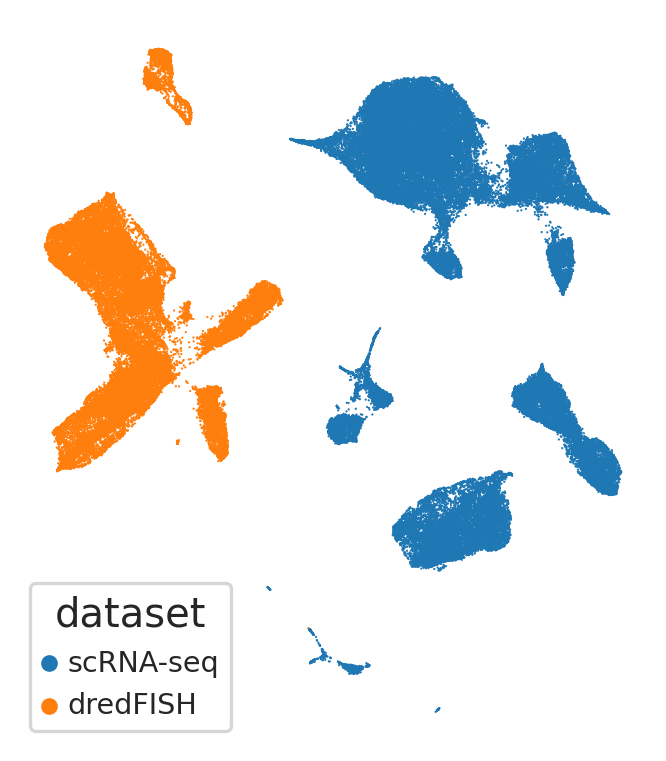

In [14]:
fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(data=dfembed.sample(frac=1), 
                x='embed_1', y='embed_2', hue='dataset',
                s=1, 
                edgecolor="none",
               )
ax.axis('off')
ax.set_aspect('equal')
plt.show()